# PayPal Fraud Detection

Author: Daniel Lee ([LinkedIn](https://www.linkedin.com/in/danleedata/))

A data science project inspired by a real-world problem.

👉 To upskill in data science: [datascienceschool.com](https://datascienceschool.com) <br>
👉 To ace interviews in data/ML: [datainterview.com](https://datainterview.com)

------

In [1]:
#@title Setup
import numpy as np
import pandas as pd

# Set seed for consistent result
SEED = 123
np.random.seed(SEED)

# 🎯 Step 1 - Problem Definition

Build a data science solution that addresses the following:

1. Fraud Model: Build a model that predicts the likelihood of a transaction being fraudulent based on user and transaction features. You will be provided with a dataset containing historical user information (e.g., account creation date, country, KYC status) and transaction details (e.g., currency, amount, merchant category).

2. Operationalization: How will you utilize this model to catch fraudsters? If a fraudster is identified, what should be the resulting action: LOCK_USER, ALERT_AGENT, or BOTH?

*   **LOCK_USER** - Current transaction is blocked and user’s account is LOCKED. This prevents the user from performing any transactions with their Revolut account. Access can only be restored after contacting an agent.
*   **ALERT_AGENT** - Current transaction is not blocked. An alert is sent to a transaction monitoring agent for further review.

In [3]:
# Load data from the data directory
import os
import sys

HOME = os.getcwd()
print(HOME)
%cd {HOME}
!mkdir -p {HOME}/data

# Load data
df_users = pd.read_csv('data/paypal_users.csv')
df_transactions = pd.read_csv('data/paypal_transactions.csv')

print(f"Users data shape: {df_users.shape}")
print(f"Transactions data shape: {df_transactions.shape}")
print(f"Fraud rate: {df_users['is_fraud'].mean():.4f} ({df_users['is_fraud'].mean()*100:.2f}%)")

/content
/content
Users data shape: (9944, 10)
Transactions data shape: (27699, 12)
Fraud rate: 0.0300 (3.00%)


In [4]:
# User Data
df_users.head()

,id,has_email,phone_country,terms_version,created_date,country,birth_year,kyc,failed_sign_in_attempts,is_fraud
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2024-05-23,2023-08-05 07:33:33.341,GB,1971,PASSED,0,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,2023-12-31,2023-03-06 10:18:59.427,GB,1982,PASSED,0,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,2024-09-18,2024-05-29 04:41:24.672,ES,1973,PASSED,0,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,2024-05-23,2024-05-30 17:24:23.852,FR,1986,PASSED,0,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,2024-09-18,2023-08-08 15:03:33.945,GB,1989,PASSED,0,0


In [5]:
# Transaction Data
df_transactions.head()

,currency,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,amount_usd,is_crypto
0,GBP,COMPLETED,2023-12-19 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8,220.0,False
1,EUR,COMPLETED,2023-12-19 12:38:47.232,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,853d9ff8-a007-40ef-91a2-7d81e29a309a,2885.0,False
2,EUR,COMPLETED,2023-12-19 12:34:39.668,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,04de8238-7828-4e46-91f1-050a9aa7a9df,1198.0,False
3,GBP,COMPLETED,2023-12-19 12:45:50.555,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,2b790b9b-c312-4098-a4b3-4830fc8cda53,249.0,False
4,EUR,COMPLETED,2023-12-19 12:45:32.722,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,6469fc3a-e535-41e9-91b9-acb46d1cc65d,1101.0,False


# 🗺️ Step 2 - Exploratory Data Analysis

✍️ The Exploratory Data Analysis (EDA) section delves into the provided paypal dataset to understand its characteristics, identify patterns, and uncover insights that inform model development. Here's a guideline you can consider when approaching section:

1. Generate tables and/or charts that illustrate insights.
2. Identify potential data quality issues that require addressing.
3. Discover patterns and trends that can guide feature engineering and model selection.

## Overview

In [6]:
# YOUR CODE BELOW
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

print("=== DATASET OVERVIEW ===")
print(f"👥 Users Dataset: {df_users.shape[0]:,} users, {df_users.shape[1]} features")
print(f"💳 Transactions Dataset: {df_transactions.shape[0]:,} transactions, {df_transactions.shape[1]} features")
print()

print("=== USER DATA COLUMNS ===")
for i, col in enumerate(df_users.columns, 1):
    print(f"{i:2d}. {col} ({df_users[col].dtype})")
print()

print("=== TRANSACTION DATA COLUMNS ===")
for i, col in enumerate(df_transactions.columns, 1):
    print(f"{i:2d}. {col} ({df_transactions[col].dtype})")
print()

# Check for missing values
print("=== MISSING VALUES ===")
print("Users data:")
print(df_users.isnull().sum())
print("\nTransactions data:")
print(df_transactions.isnull().sum())

=== DATASET OVERVIEW ===
👥 Users Dataset: 9,944 users, 10 features
💳 Transactions Dataset: 27,699 transactions, 12 features

=== USER DATA COLUMNS ===
 1. id (object)
 2. has_email (int64)
 3. phone_country (object)
 4. terms_version (object)
 5. created_date (object)
 6. country (object)
 7. birth_year (int64)
 8. kyc (object)
 9. failed_sign_in_attempts (int64)
10. is_fraud (int64)

=== TRANSACTION DATA COLUMNS ===
 1. currency (object)
 2. state (object)
 3. created_date (object)
 4. merchant_category (object)
 5. merchant_country (object)
 6. entry_method (object)
 7. user_id (object)
 8. type (object)
 9. source (object)
10. id (object)
11. amount_usd (float64)
12. is_crypto (object)

=== MISSING VALUES ===
Users data:
id                            0
has_email                     0
phone_country                 0
terms_version              1527
created_date                  0
country                       0
birth_year                    0
kyc                           0
failed_sig

## Users

In [7]:
# YOUR CODE BELOW
# User Data Analysis
print("=== USER FRAUD DISTRIBUTION ===")
fraud_counts = df_users['is_fraud'].value_counts()
fraud_rate = df_users['is_fraud'].mean()
print(f"Total users: {len(df_users):,}")
print(f"Fraudulent users: {fraud_counts[1]:,} ({fraud_rate*100:.2f}%)")
print(f"Legitimate users: {fraud_counts[0]:,} ({(1-fraud_rate)*100:.2f}%)")
print()

# Country analysis
print("=== TOP 10 COUNTRIES ===")
country_stats = df_users.groupby('country').agg({
    'id': 'count',
    'is_fraud': ['sum', 'mean']
}).round(4)
country_stats.columns = ['total_users', 'fraud_count', 'fraud_rate']
country_stats = country_stats.sort_values('total_users', ascending=False)
print(country_stats.head(10))
print()

# KYC Status analysis
print("=== KYC STATUS DISTRIBUTION ===")
kyc_stats = df_users.groupby('kyc').agg({
    'id': 'count',
    'is_fraud': ['sum', 'mean']
}).round(4)
kyc_stats.columns = ['total_users', 'fraud_count', 'fraud_rate']
print(kyc_stats)
print()

# Age analysis
print("=== AGE DISTRIBUTION ===")
current_year = 2025
df_users['age'] = current_year - df_users['birth_year']
age_stats = df_users.groupby(pd.cut(df_users['age'], bins=[0, 25, 35, 50, 65, 100])).agg({
    'id': 'count',
    'is_fraud': ['sum', 'mean']
}).round(4)
age_stats.columns = ['total_users', 'fraud_count', 'fraud_rate']
print(age_stats)

=== USER FRAUD DISTRIBUTION ===
Total users: 9,944
Fraudulent users: 298 (3.00%)
Legitimate users: 9,646 (97.00%)

=== TOP 10 COUNTRIES ===
         total_users  fraud_count  fraud_rate
country                                      
GB              4437          268      0.0604
FR              1322            3      0.0023
PL               666            2      0.0030
LT               491           14      0.0285
IE               413            0      0.0000
ES               393            3      0.0076
GR               287            0      0.0000
RO               220            4      0.0182
DE               219            1      0.0046
CH               184            0      0.0000

=== KYC STATUS DISTRIBUTION ===
         total_users  fraud_count  fraud_rate
kyc                                          
FAILED           270           22      0.0815
NONE            2631            1      0.0004
PASSED          6969          259      0.0372
PENDING           74           16      0.2162

/tmp/ipython-input-7-3597182073.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df_users.groupby(pd.cut(df_users['age'], bins=[0, 25, 35, 50, 65, 100])).agg({


## Transaction

In [8]:
# Transaction Data Analysis
print("=== TRANSACTION STATISTICS ===")
print(f"Total transactions: {len(df_transactions):,}")
print(f"Unique users with transactions: {df_transactions['user_id'].nunique():,}")
print(f"Average transactions per user: {len(df_transactions) / df_transactions['user_id'].nunique():.1f}")
print()

# Amount analysis
print("=== AMOUNT STATISTICS ===")
print(df_transactions['amount_usd'].describe())
print()

# Transaction types
print("=== TRANSACTION TYPES ===")
type_counts = df_transactions['type'].value_counts()
for txn_type, count in type_counts.items():
    pct = count / len(df_transactions) * 100
    print(f"{txn_type}: {count:,} ({pct:.1f}%)")
print()

# Transaction states
print("=== TRANSACTION STATES ===")
state_counts = df_transactions['state'].value_counts()
for state, count in state_counts.items():
    pct = count / len(df_transactions) * 100
    print(f"{state}: {count:,} ({pct:.1f}%)")
print()

# Currency analysis
print("=== TOP 10 CURRENCIES ===")
currency_counts = df_transactions['currency'].value_counts().head(10)
for currency, count in currency_counts.items():
    pct = count / len(df_transactions) * 100
    print(f"{currency}: {count:,} ({pct:.1f}%)")
print()

# Merchant categories
print("=== TOP 10 MERCHANT CATEGORIES ===")
merchant_counts = df_transactions['merchant_category'].value_counts().head(10)
for category, count in merchant_counts.items():
    pct = count / len(df_transactions) * 100
    print(f"{category}: {count:,} ({pct:.1f}%)")
print()

# Entry methods
print("=== ENTRY METHODS ===")
entry_counts = df_transactions['entry_method'].value_counts()
for method, count in entry_counts.items():
    pct = count / len(df_transactions) * 100
    print(f"{method}: {count:,} ({pct:.1f}%)")

=== TRANSACTION STATISTICS ===
Total transactions: 27,699
Unique users with transactions: 1,921
Average transactions per user: 14.4

=== AMOUNT STATISTICS ===
count    2.769800e+04
mean     5.480220e+06
std      2.700900e+08
min      0.000000e+00
25%      6.300000e+02
50%      1.774500e+03
75%      5.983750e+03
max      1.939915e+10
Name: amount_usd, dtype: float64

=== TRANSACTION TYPES ===
CARD_PAYMENT: 18,513 (66.8%)
TOPUP: 5,994 (21.6%)
ATM: 1,506 (5.4%)
BANK_TRANSFER: 1,007 (3.6%)
P2P: 679 (2.5%)

=== TRANSACTION STATES ===
COMPLETED: 23,554 (85.0%)
REVERTED: 1,714 (6.2%)
DECLINED: 1,525 (5.5%)
FAILED: 888 (3.2%)
CANCELLED: 18 (0.1%)

=== TOP 10 CURRENCIES ===
GBP: 13,334 (48.1%)
EUR: 10,828 (39.1%)
USD: 1,010 (3.6%)
PLN: 782 (2.8%)
AUD: 458 (1.7%)
CHF: 433 (1.6%)
RON: 96 (0.3%)
HUF: 88 (0.3%)
ZAR: 71 (0.3%)
NZD: 67 (0.2%)

=== TOP 10 MERCHANT CATEGORIES ===
point_of_interest: 1,644 (5.9%)
supermarket: 1,201 (4.3%)
restaurant: 1,032 (3.7%)
cafe: 623 (2.2%)
bar: 585 (2.1%)
store: 4

## Plotting

/tmp/ipython-input-9-2043393213.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([df_merged[df_merged['is_fraud']==0]['amount_usd'].values,


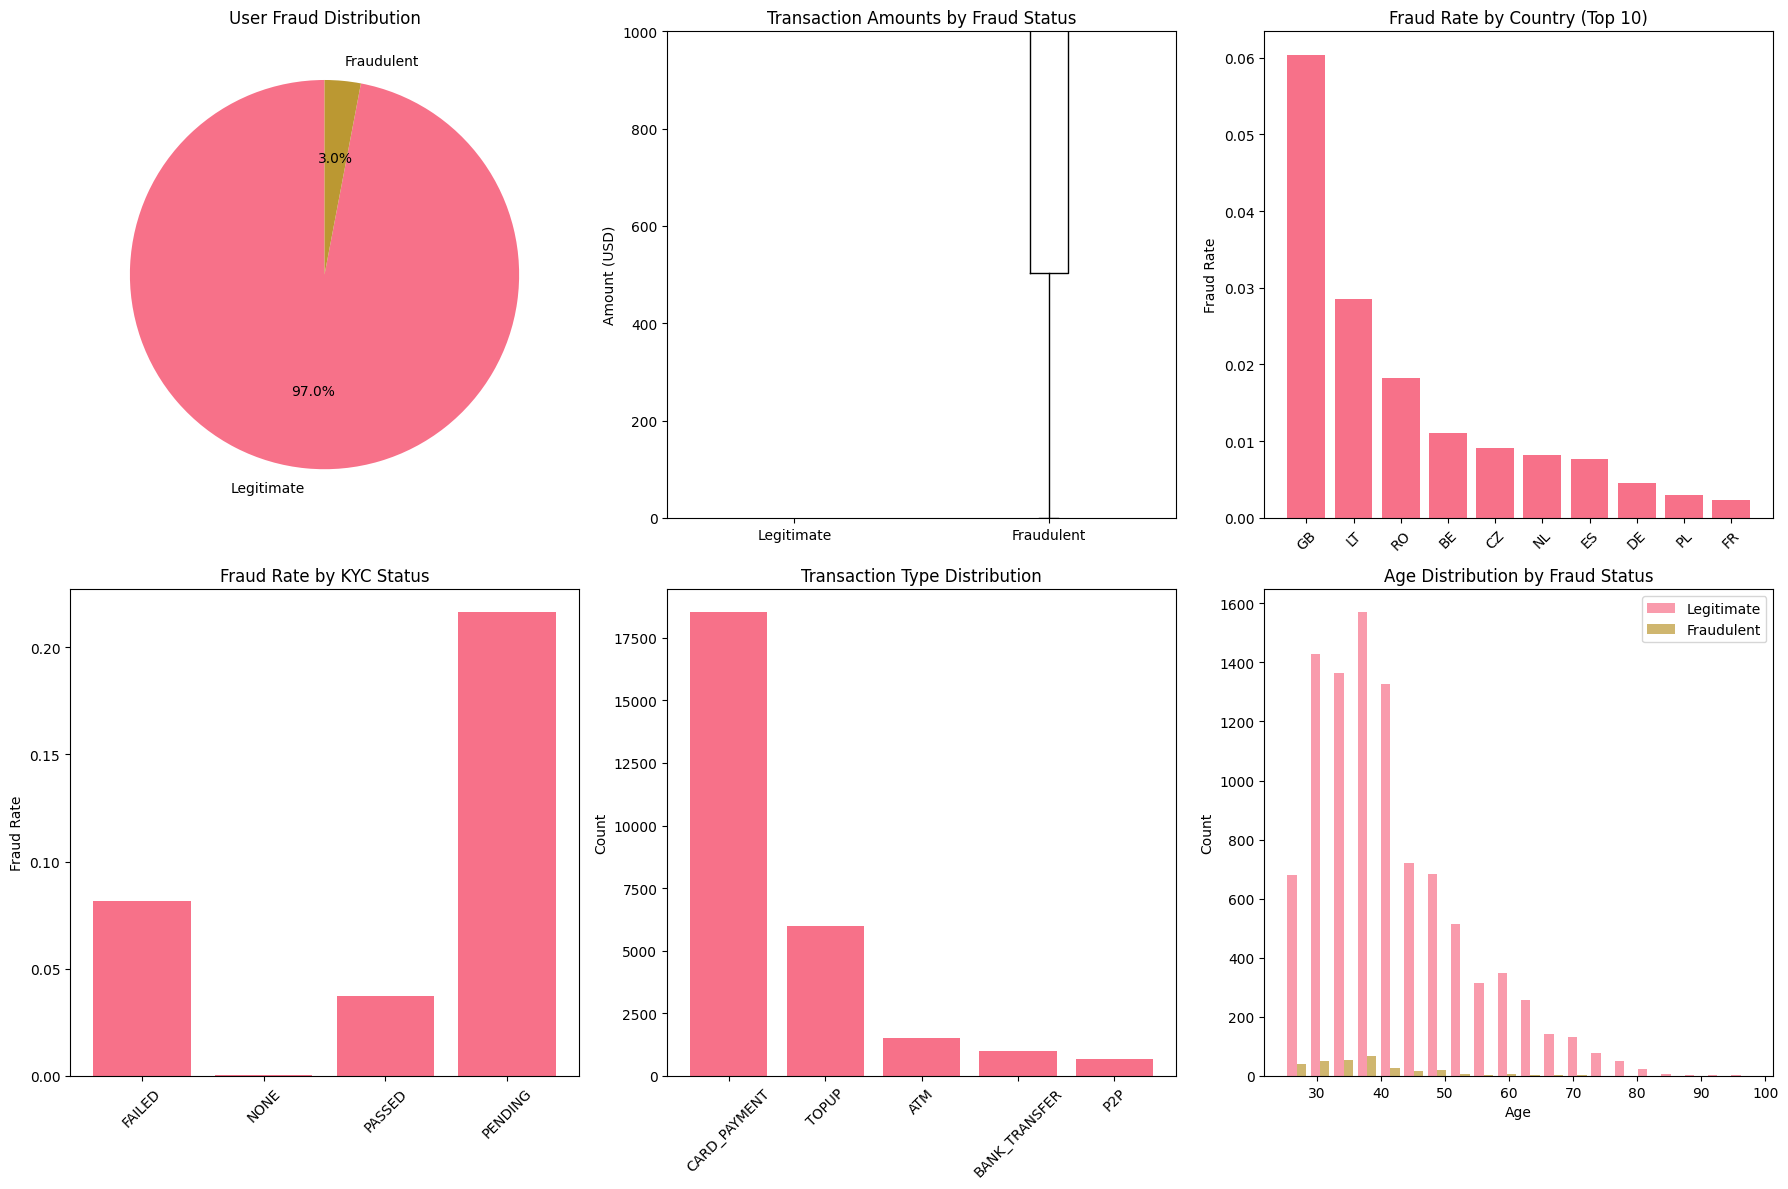

=== CORRELATION WITH FRAUD ===
has_email: 0.0391
birth_year: 0.0575
failed_sign_in_attempts: 0.0118

=== FRAUD RATES BY PHONE COUNTRY ===
     phone_country  count      mean
80      US||PR||CA     20  0.100000
28  GB||JE||IM||GG   4302  0.061134
69              RO    227  0.030837
47              LT    492  0.028455
18              CZ    114  0.008772
60              NL    120  0.008333
25              ES    411  0.007299
67              PT    144  0.006944
66              PL    672  0.002976
27              FR   1309  0.002292


In [9]:
# YOUR CODE BELOW
# Data Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Fraud distribution
fraud_counts = df_users['is_fraud'].value_counts()
axes[0,0].pie(fraud_counts.values, labels=['Legitimate', 'Fraudulent'],
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('User Fraud Distribution')

# 2. Transaction amounts by fraud status
# Merge with user fraud data
df_merged = df_transactions.merge(df_users[['id', 'is_fraud']],
                                  left_on='user_id', right_on='id', how='left')
df_merged['is_fraud'] = df_merged['is_fraud'].fillna(0)

axes[0,1].boxplot([df_merged[df_merged['is_fraud']==0]['amount_usd'].values,
                   df_merged[df_merged['is_fraud']==1]['amount_usd'].values],
                  labels=['Legitimate', 'Fraudulent'])
axes[0,1].set_title('Transaction Amounts by Fraud Status')
axes[0,1].set_ylabel('Amount (USD)')
axes[0,1].set_ylim(0, 1000)  # Limit for better visibility

# 3. Country fraud rates (top 10 countries)
country_fraud = df_users.groupby('country')['is_fraud'].agg(['count', 'mean']).reset_index()
country_fraud = country_fraud[country_fraud['count'] >= 50]  # Min 50 users
country_fraud = country_fraud.sort_values('mean', ascending=False).head(10)

axes[0,2].bar(range(len(country_fraud)), country_fraud['mean'])
axes[0,2].set_title('Fraud Rate by Country (Top 10)')
axes[0,2].set_ylabel('Fraud Rate')
axes[0,2].set_xticks(range(len(country_fraud)))
axes[0,2].set_xticklabels(country_fraud['country'], rotation=45)

# 4. KYC status vs fraud
kyc_fraud = df_users.groupby('kyc')['is_fraud'].mean()
axes[1,0].bar(kyc_fraud.index, kyc_fraud.values)
axes[1,0].set_title('Fraud Rate by KYC Status')
axes[1,0].set_ylabel('Fraud Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Transaction type distribution
type_counts = df_transactions['type'].value_counts()
axes[1,1].bar(type_counts.index, type_counts.values)
axes[1,1].set_title('Transaction Type Distribution')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Age distribution by fraud status
df_users['age'] = 2025 - df_users['birth_year']
axes[1,2].hist([df_users[df_users['is_fraud']==0]['age'],
                df_users[df_users['is_fraud']==1]['age']],
               bins=20, alpha=0.7, label=['Legitimate', 'Fraudulent'])
axes[1,2].set_title('Age Distribution by Fraud Status')
axes[1,2].set_xlabel('Age')
axes[1,2].set_ylabel('Count')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Additional correlation analysis
print("=== CORRELATION WITH FRAUD ===")
# Numerical correlations
numerical_cols = ['has_email', 'birth_year', 'failed_sign_in_attempts']
for col in numerical_cols:
    if col in df_users.columns:
        corr = df_users[col].corr(df_users['is_fraud'])
        print(f"{col}: {corr:.4f}")

# Categorical analysis
print("\n=== FRAUD RATES BY PHONE COUNTRY ===")
phone_fraud = df_users.groupby('phone_country')['is_fraud'].agg(['count', 'mean']).reset_index()
phone_fraud = phone_fraud[phone_fraud['count'] >= 20]  # Min 20 users
phone_fraud = phone_fraud.sort_values('mean', ascending=False)
print(phone_fraud.head(10))

# 🛢️ Step 3 - Data Preparation

✍️ Data preparation transforms raw data into a suitable format for machine learning models, enhancing their accuracy and efficiency. Your task is to clean, transform, and organize the paypal data. Here are suggestions:

*   Format Fields: Ensure data types are appropriate for analysis (e.g., datetime, categorical).
*   Split Data: Divide the dataset into training and testing sets to evaluate model performance robustly.

💡 You are not restricted to these steps. If you identify additional steps to enhance the data, feel free to include them!

In [10]:
# Data Preparation
from datetime import datetime
from sklearn.model_selection import train_test_split

# 1. Format Fields
print("=== DATA FORMATTING ===")

# Convert datetime fields
df_users['created_date'] = pd.to_datetime(df_users['created_date'])
df_transactions['created_date'] = pd.to_datetime(df_transactions['created_date'])

print("✅ Date fields converted to datetime")

# Handle categorical variables
categorical_user_cols = ['phone_country', 'country', 'kyc']
categorical_txn_cols = ['currency', 'state', 'merchant_category', 'merchant_country', 'entry_method', 'type', 'source']

print(f"✅ Identified categorical columns: {len(categorical_user_cols + categorical_txn_cols)} total")

# 2. Data Quality Checks
print("\n=== DATA QUALITY CHECKS ===")

# Check for duplicate users
duplicate_users = df_users['id'].duplicated().sum()
print(f"Duplicate users: {duplicate_users}")

# Check for duplicate transactions
duplicate_txns = df_transactions['id'].duplicated().sum()
print(f"Duplicate transactions: {duplicate_txns}")

# Check for orphaned transactions (transactions without user data)
valid_users = set(df_users['id'])
orphaned_txns = df_transactions[~df_transactions['user_id'].isin(valid_users)]
print(f"Orphaned transactions: {len(orphaned_txns)}")

# Check for invalid amounts
invalid_amounts = (df_transactions['amount_usd'] <= 0).sum()
print(f"Invalid amounts (≤ 0): {invalid_amounts}")

# 3. Create merged dataset for analysis
print("\n=== CREATING MERGED DATASET ===")

# Merge transaction data with user fraud labels
df_merged = df_transactions.merge(
    df_users[['id', 'is_fraud']],
    left_on='user_id',
    right_on='id',
    how='left',
    suffixes=('_txn', '_user')
)

# Fill missing fraud labels (for orphaned transactions)
df_merged['is_fraud'] = df_merged['is_fraud'].fillna(0).astype(int)

print(f"Merged dataset shape: {df_merged.shape}")
print(f"Fraud rate in transactions: {df_merged['is_fraud'].mean():.4f}")

# 4. Split Data for Model Training
print("\n=== DATA SPLITTING ===")

# Create a balanced sample for training (due to large dataset size)
fraud_transactions = df_merged[df_merged['is_fraud'] == 1]
legit_transactions = df_merged[df_merged['is_fraud'] == 0].sample(n=min(50000, len(df_merged[df_merged['is_fraud'] == 0])), random_state=SEED)

# Combine for balanced training set
training_data = pd.concat([fraud_transactions, legit_transactions], ignore_index=True).sample(frac=1, random_state=SEED)

print(f"Training data shape: {training_data.shape}")
print(f"Training fraud rate: {training_data['is_fraud'].mean():.4f}")

# Split into train/validation/test
train_data, temp_data = train_test_split(training_data, test_size=0.4, random_state=SEED, stratify=training_data['is_fraud'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=SEED, stratify=temp_data['is_fraud'])

print(f"Train set: {train_data.shape} (fraud rate: {train_data['is_fraud'].mean():.4f})")
print(f"Validation set: {val_data.shape} (fraud rate: {val_data['is_fraud'].mean():.4f})")
print(f"Test set: {test_data.shape} (fraud rate: {test_data['is_fraud'].mean():.4f})")

print("✅ Data preparation completed!")

=== DATA FORMATTING ===
✅ Date fields converted to datetime
✅ Identified categorical columns: 10 total

=== DATA QUALITY CHECKS ===
Duplicate users: 0
Duplicate transactions: 0
Orphaned transactions: 0
Invalid amounts (≤ 0): 536

=== CREATING MERGED DATASET ===
Merged dataset shape: (27699, 14)
Fraud rate in transactions: 0.0185

=== DATA SPLITTING ===
Training data shape: (27699, 14)
Training fraud rate: 0.0185
Train set: (16619, 14) (fraud rate: 0.0185)
Validation set: (5540, 14) (fraud rate: 0.0186)
Test set: (5540, 14) (fraud rate: 0.0184)
✅ Data preparation completed!


# 🚀 Step 4 - Feature Engineering

✍️ Feature engineering boosts model performance! It's about creating new features from existing ones to help the model better understand the data and improve predictions.

Here are suggestions to help you create new features:

1. **Dummy Encoding**: Consider applying dummy encoding on categorical variables. But beaware of sparsity!
2. **Decompose Timestamps**: Decompose timestamp into year, month, day of year, and such.
3. **Aggregations**: Consider aggregating $ amount to profile transaction history of users.

💡 If you think of any other features that could be insightful, go ahead and experiment. Feature engineering is all about finding what works best for your model!

In [13]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

def create_user_features(users_df):
    """Create user-level features."""
    df = users_df.copy()

    # Basic features
    df['has_email'] = df['has_email'].astype(int)

    # Account age
    df['created_date'] = pd.to_datetime(df['created_date'])
    current_time = pd.to_datetime('2025-06-22')
    df['account_age_days'] = (current_time - df['created_date']).dt.days
    df['account_age_hours'] = (current_time - df['created_date']).dt.total_seconds() / 3600

    # Age features
    current_year = 2025
    df['user_age'] = current_year - df['birth_year']
    df['is_young_user'] = (df['user_age'] < 25).astype(int)
    df['is_senior_user'] = (df['user_age'] > 65).astype(int)

    # KYC features
    df['kyc_passed'] = (df['kyc'] == 'PASSED').astype(int)
    df['kyc_failed'] = (df['kyc'] == 'FAILED').astype(int)
    df['kyc_pending'] = (df['kyc'] == 'PENDING').astype(int)
    df['kyc_none'] = (df['kyc'] == 'NONE').astype(int)

    # Phone country features
    df['phone_country_matches_country'] = (df['phone_country'] == df['country']).astype(int)

    # Failed sign-in attempts features
    df['has_failed_signin'] = (df['failed_sign_in_attempts'] > 0).astype(int)
    df['multiple_failed_signin'] = (df['failed_sign_in_attempts'] > 1).astype(int)

    # Terms version features
    if 'terms_version' in df.columns:
        df['terms_version'] = df['terms_version'].fillna('2023-01-01')
        df['terms_version_date'] = pd.to_datetime(df['terms_version'])
        df['terms_version_age_days'] = (current_time - df['terms_version_date']).dt.days
    else:
        df['terms_version_age_days'] = 365  # Default

    return df

def create_transaction_features(transactions_df):
    """Create transaction-level features."""
    df = transactions_df.copy()

    # Basic transaction features
    df['amount_usd_log'] = np.log1p(df['amount_usd'])

    # Handle is_crypto column with proper NaN handling
    if 'is_crypto' in df.columns:
        df['is_crypto'] = df['is_crypto'].fillna(False).astype(int)
    else:
        df['is_crypto'] = 0

    # Transaction state features
    if 'state' in df.columns:
        df['is_completed'] = (df['state'] == 'COMPLETED').astype(int)
        df['is_declined'] = (df['state'] == 'DECLINED').astype(int)
        df['is_failed'] = (df['state'] == 'FAILED').astype(int)
        df['is_reverted'] = (df['state'] == 'REVERTED').astype(int)
    else:
        df['is_completed'] = 1
        df['is_declined'] = 0
        df['is_failed'] = 0
        df['is_reverted'] = 0

    # Time features
    df['created_date'] = pd.to_datetime(df['created_date'])
    df['hour_of_day'] = df['created_date'].dt.hour
    df['day_of_week'] = df['created_date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'].isin([5, 6])).astype(int)
    df['is_night_time'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] <= 6)).astype(int)
    df['is_business_hours'] = ((df['hour_of_day'] >= 9) & (df['hour_of_day'] <= 17)).astype(int)

    # Entry method features - handle missing values
    entry_methods = ['chip', 'cont', 'manu', 'misc', 'mags', 'mcon']
    for method in entry_methods:
        df[f'entry_method_{method}'] = (df['entry_method'].fillna('unknown') == method).astype(int)

    # Transaction type features - handle missing values
    transaction_types = ['CARD_PAYMENT', 'TOPUP', 'ATM', 'BANK_TRANSFER', 'P2P']
    for txn_type in transaction_types:
        df[f'type_{txn_type}'] = (df['type'].fillna('unknown') == txn_type).astype(int)

    # Source features - handle missing values
    sources = ['GAIA', 'HERA', 'INTERNAL', 'LETO', 'MINOS', 'CRONUS']
    for source in sources:
        df[f'source_{source}'] = (df['source'].fillna('unknown') == source).astype(int)

    # Currency features - handle missing values
    major_currencies = ['GBP', 'EUR', 'USD']
    for currency in major_currencies:
        df[f'currency_{currency}'] = (df['currency'].fillna('unknown') == currency).astype(int)

    # Amount features
    df['is_high_amount'] = (df['amount_usd'] > df['amount_usd'].quantile(0.95)).astype(int)
    df['is_low_amount'] = (df['amount_usd'] < df['amount_usd'].quantile(0.05)).astype(int)
    df['is_round_amount'] = (df['amount_usd'] % 100 == 0).astype(int)

    return df

def create_user_transaction_aggregates(transactions_df, lookback_days=7):
    """Create user-level aggregated features from transaction history."""
    df = transactions_df.copy()

    # Filter recent transactions
    current_time = pd.to_datetime('2025-06-22')
    cutoff_date = current_time - pd.Timedelta(days=lookback_days)
    recent_df = df[df['created_date'] >= cutoff_date]

    # Define base aggregation columns
    agg_dict = {
        'amount_usd': ['count', 'sum', 'mean', 'std', 'min', 'max']
    }

    # Add optional columns if they exist in the dataframe
    optional_columns = ['is_completed', 'is_declined', 'is_failed', 'is_night_time', 'is_weekend']
    for col in optional_columns:
        if col in recent_df.columns:
            agg_dict[col] = 'sum'

    # Aggregate features per user
    agg_features = recent_df.groupby('user_id').agg(agg_dict).reset_index()

    # Flatten column names
    new_columns = ['user_id']
    for col in agg_features.columns[1:]:
        if isinstance(col, tuple):
            new_columns.append(f'user_{col[1]}_{col[0]}')
        else:
            new_columns.append(f'user_{col}')

    agg_features.columns = new_columns

    # Calculate additional features
    agg_features['user_transaction_frequency'] = agg_features['user_count_amount_usd'] / lookback_days
    agg_features['user_avg_daily_amount'] = agg_features['user_sum_amount_usd'] / lookback_days

    # Calculate decline rate if the column exists
    if 'user_sum_is_declined' in agg_features.columns:
        agg_features['user_decline_rate'] = (
            agg_features['user_sum_is_declined'] / agg_features['user_count_amount_usd']
        ).fillna(0)
    else:
        agg_features['user_decline_rate'] = 0.0

    # Calculate night transaction rate if the column exists
    if 'user_sum_is_night_time' in agg_features.columns:
        agg_features['user_night_transaction_rate'] = (
            agg_features['user_sum_is_night_time'] / agg_features['user_count_amount_usd']
        ).fillna(0)
    else:
        agg_features['user_night_transaction_rate'] = 0.0

    # Fill NaN values
    agg_features = agg_features.fillna(0)

    return agg_features

# Apply feature engineering to our datasets
print("\n=== CREATING FEATURES ===")

# Create user features for training data
train_users = df_users[df_users['id'].isin(train_data['user_id'])]
train_user_features = create_user_features(train_users)

# Create transaction features for training data
train_transaction_features = create_transaction_features(train_data)

# Create user aggregated features
train_user_agg_features = create_user_transaction_aggregates(train_transaction_features)

# Merge all features for training set
train_features = train_transaction_features.merge(
    train_user_features, left_on='user_id', right_on='id', how='left', suffixes=('', '_user')
).merge(
    train_user_agg_features, on='user_id', how='left'
)

# Select feature columns (remove ID columns and non-numeric columns)
excluded_columns = [
    'id', 'user_id', 'id_user', 'is_fraud', 'created_date', 'created_date_user',
    'currency', 'state', 'merchant_category', 'merchant_country', 'entry_method',
    'type', 'source', 'phone_country', 'terms_version', 'country', 'kyc',
    'terms_version_date'
]

feature_columns = [col for col in train_features.columns
                  if col not in excluded_columns]

train_features_final = train_features[feature_columns].fillna(0)

# Ensure all features are numeric
print("=== ENSURING NUMERIC FEATURES ===")
numeric_features = []
for col in feature_columns:
    try:
        # Try to convert to numeric
        train_features_final[col] = pd.to_numeric(train_features_final[col], errors='coerce')
        # Check if column has any non-null values after conversion
        if not train_features_final[col].isna().all():
            numeric_features.append(col)
        else:
            print(f"Dropped non-numeric column: {col}")
    except:
        print(f"Dropped problematic column: {col}")

# Update features to only include numeric columns
train_features_final = train_features_final[numeric_features].fillna(0)
train_labels = train_data['is_fraud']

print(f"Training features shape: {train_features_final.shape}")
print(f"Number of numeric features: {len(numeric_features)}")
print(f"Feature columns:")
for i, col in enumerate(numeric_features, 1):
    print(f"  {i:2d}. {col}")

# Apply same feature engineering to validation and test sets
print("\n=== CREATING VALIDATION AND TEST FEATURES ===")

# Validation set
val_users = df_users[df_users['id'].isin(val_data['user_id'])]
val_user_features = create_user_features(val_users)
val_transaction_features = create_transaction_features(val_data)
val_user_agg_features = create_user_transaction_aggregates(val_transaction_features)

val_features = val_transaction_features.merge(
    val_user_features, left_on='user_id', right_on='id', how='left', suffixes=('', '_user')
).merge(
    val_user_agg_features, on='user_id', how='left'
)

val_features_final = val_features[numeric_features].fillna(0)
# Ensure all are numeric
for col in numeric_features:
    val_features_final[col] = pd.to_numeric(val_features_final[col], errors='coerce').fillna(0)

val_labels = val_data['is_fraud']

# Test set
test_users = df_users[df_users['id'].isin(test_data['user_id'])]
test_user_features = create_user_features(test_users)
test_transaction_features = create_transaction_features(test_data)
test_user_agg_features = create_user_transaction_aggregates(test_transaction_features)

test_features = test_transaction_features.merge(
    test_user_features, left_on='user_id', right_on='id', how='left', suffixes=('', '_user')
).merge(
    test_user_agg_features, on='user_id', how='left'
)

test_features_final = test_features[numeric_features].fillna(0)
# Ensure all are numeric
for col in numeric_features:
    test_features_final[col] = pd.to_numeric(test_features_final[col], errors='coerce').fillna(0)

test_labels = test_data['is_fraud']

print(f"Validation features shape: {val_features_final.shape}")
print(f"Test features shape: {test_features_final.shape}")

# Feature statistics
print("\n=== FEATURE STATISTICS ===")
print("Training features summary:")
print(train_features_final.describe().round(4))

# Check for missing values
missing_features = train_features_final.isnull().sum()
if missing_features.sum() > 0:
    print(f"\n⚠️  Missing values found: {missing_features.sum()}")
    print(missing_features[missing_features > 0])
else:
    print("\n✅ No missing values in features")

# Feature correlation with target - now with proper numeric validation
print("\n=== TOP 15 FEATURES CORRELATED WITH FRAUD ===")
feature_correlations = []

for col in train_features_final.columns:
    try:
        # Ensure both series are numeric
        feature_series = pd.to_numeric(train_features_final[col], errors='coerce')
        target_series = pd.to_numeric(train_labels, errors='coerce')

        # Calculate correlation only if both series have valid numeric data
        if not feature_series.isna().all() and not target_series.isna().all():
            corr = feature_series.corr(target_series)
            if not np.isnan(corr):
                feature_correlations.append((col, abs(corr), corr))
    except Exception as e:
        print(f"Skipped correlation for {col}: {e}")
        continue

# Sort by absolute correlation
feature_correlations.sort(key=lambda x: x[1], reverse=True)

if feature_correlations:
    for i, (feature, abs_corr, corr) in enumerate(feature_correlations[:15], 1):
        print(f"{i:2d}. {feature}: {corr:+.4f}")
else:
    print("⚠️  No valid correlations could be calculated")

print("✅ Feature engineering completed!")

=== FEATURE ENGINEERING ===

=== CREATING FEATURES ===


/tmp/ipython-input-13-3559585539.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_crypto'] = df['is_crypto'].fillna(False).astype(int)


=== ENSURING NUMERIC FEATURES ===
Dropped non-numeric column: id_txn
Training features shape: (16619, 68)
Number of numeric features: 68
Feature columns:
   1. amount_usd
   2. is_crypto
   3. amount_usd_log
   4. is_completed
   5. is_declined
   6. is_failed
   7. is_reverted
   8. hour_of_day
   9. day_of_week
  10. is_weekend
  11. is_night_time
  12. is_business_hours
  13. entry_method_chip
  14. entry_method_cont
  15. entry_method_manu
  16. entry_method_misc
  17. entry_method_mags
  18. entry_method_mcon
  19. type_CARD_PAYMENT
  20. type_TOPUP
  21. type_ATM
  22. type_BANK_TRANSFER
  23. type_P2P
  24. source_GAIA
  25. source_HERA
  26. source_INTERNAL
  27. source_LETO
  28. source_MINOS
  29. source_CRONUS
  30. currency_GBP
  31. currency_EUR
  32. currency_USD
  33. is_high_amount
  34. is_low_amount
  35. is_round_amount
  36. has_email
  37. birth_year
  38. failed_sign_in_attempts
  39. is_fraud_user
  40. age
  41. account_age_days
  42. account_age_hours
  43. use

/tmp/ipython-input-13-3559585539.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_crypto'] = df['is_crypto'].fillna(False).astype(int)
/tmp/ipython-input-13-3559585539.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_crypto'] = df['is_crypto'].fillna(False).astype(int)


Validation features shape: (5540, 68)
Test features shape: (5540, 68)

=== FEATURE STATISTICS ===
Training features summary:
         amount_usd   is_crypto  amount_usd_log  is_completed  is_declined  \
count  1.661900e+04  16619.0000      16619.0000    16619.0000   16619.0000   
mean   6.008686e+06      0.0011          7.5245        0.8518       0.0559   
std    2.927845e+08      0.0338          2.0388        0.3553       0.2297   
min    0.000000e+00      0.0000          0.0000        0.0000       0.0000   
25%    6.340000e+02      0.0000          6.4536        1.0000       0.0000   
50%    1.829000e+03      0.0000          7.5121        1.0000       0.0000   
75%    6.212000e+03      0.0000          8.7344        1.0000       0.0000   
max    1.939915e+10      1.0000         23.6885        1.0000       1.0000   

        is_failed  is_reverted  hour_of_day  day_of_week  is_weekend  ...  \
count  16619.0000   16619.0000   16619.0000   16619.0000  16619.0000  ...   
mean       0.0304 

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# 📍 Step 5 - Feature Selection

✍️ Feature selection prevents model overfitting and improves training speed. Find the most relevant features for model prediction. You can consider a method such as the univariate Feature Importance. Be aware of multicollinearity!

In [15]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("=== FEATURE SELECTION ANALYSIS ===")

# Use the cleaned numeric features from Step 4
print(f"Using {train_features_final.shape[1]} numeric features for selection")

# 1. Univariate Feature Selection
print("\n1. UNIVARIATE FEATURE SELECTION (F-test)")
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(train_features_final, train_labels)

f_scores = selector_f.scores_
f_rankings = np.argsort(f_scores)[::-1]

print("Top 15 features by F-score:")
for i in range(min(15, len(f_scores))):
    idx = f_rankings[i]
    feature_name = train_features_final.columns[idx]
    score = f_scores[idx]
    print(f"{i+1:2d}. {feature_name}: {score:.2f}")

# 2. Mutual Information
print("\n2. MUTUAL INFORMATION SELECTION")
mi_scores = mutual_info_classif(train_features_final, train_labels, random_state=SEED)
mi_rankings = np.argsort(mi_scores)[::-1]

print("Top 15 features by Mutual Information:")
for i in range(min(15, len(mi_scores))):
    idx = mi_rankings[i]
    feature_name = train_features_final.columns[idx]
    score = mi_scores[idx]
    print(f"{i+1:2d}. {feature_name}: {score:.4f}")

# 3. Tree-based Feature Importance
print("\n3. RANDOM FOREST FEATURE IMPORTANCE")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
rf_selector.fit(train_features_final, train_labels)

rf_importance = rf_selector.feature_importances_
rf_rankings = np.argsort(rf_importance)[::-1]

print("Top 15 features by Random Forest importance:")
for i in range(min(15, len(rf_importance))):
    idx = rf_rankings[i]
    feature_name = train_features_final.columns[idx]
    importance = rf_importance[idx]
    print(f"{i+1:2d}. {feature_name}: {importance:.4f}")

# 4. Multicollinearity Check
print("\n4. MULTICOLLINEARITY ANALYSIS")
correlation_matrix = train_features_final.corr().abs()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val > 0.8:  # High correlation threshold
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[:10]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("✅ No highly correlated feature pairs found (threshold: 0.8)")

# 5. Feature Selection Recommendation
print("\n5. FEATURE SELECTION RECOMMENDATION")

# Combine rankings with weights
f_weight = 0.3
mi_weight = 0.3
rf_weight = 0.4

combined_scores = {}
for i, feature in enumerate(train_features_final.columns):
    f_rank = np.where(f_rankings == i)[0][0] + 1
    mi_rank = np.where(mi_rankings == i)[0][0] + 1
    rf_rank = np.where(rf_rankings == i)[0][0] + 1

    # Lower rank is better, so invert
    combined_score = (
        f_weight / f_rank +
        mi_weight / mi_rank +
        rf_weight / rf_rank
    )
    combined_scores[feature] = combined_score

# Sort by combined score
recommended_features = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 20 recommended features (combined ranking):")
for i, (feature, score) in enumerate(recommended_features[:20], 1):
    print(f"{i:2d}. {feature}: {score:.4f}")

# Select top K features for model training
K_FEATURES = min(30, len(train_features_final.columns))  # Select top 30 features or all if less
selected_features = [feat for feat, _ in recommended_features[:K_FEATURES]]

print(f"\n✅ Selected {K_FEATURES} features for model training:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Create feature-selected datasets
train_features_selected = train_features_final[selected_features]
val_features_selected = val_features_final[selected_features]
test_features_selected = test_features_final[selected_features]

print(f"\nFeature-selected dataset shapes:")
print(f"Train: {train_features_selected.shape}")
print(f"Validation: {val_features_selected.shape}")
print(f"Test: {test_features_selected.shape}")

# Verify all selected features are numeric
print(f"\n=== FEATURE VALIDATION ===")
for col in selected_features:
    if train_features_selected[col].dtype not in ['int64', 'float64', 'int32', 'float32']:
        print(f"⚠️  Non-numeric feature detected: {col} ({train_features_selected[col].dtype})")
    else:
        print(f"✅ {col}: {train_features_selected[col].dtype}")

print("✅ Feature selection completed!")

=== FEATURE SELECTION ANALYSIS ===
Using 68 numeric features for selection

1. UNIVARIATE FEATURE SELECTION (F-test)
Top 15 features by F-score:
 1. user_count_amount_usd: nan
 2. user_sum_amount_usd: nan
 3. user_mean_amount_usd: nan
 4. user_std_amount_usd: nan
 5. user_min_amount_usd: nan
 6. user_max_amount_usd: nan
 7. user_sum_is_completed: nan
 8. user_sum_is_declined: nan
 9. user_sum_is_failed: nan
10. user_sum_is_night_time: nan
11. user_sum_is_weekend: nan
12. user_transaction_frequency: nan
13. user_avg_daily_amount: nan
14. user_decline_rate: nan
15. is_young_user: nan

2. MUTUAL INFORMATION SELECTION


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [38 43 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Top 15 features by Mutual Information:
 1. is_fraud_user: 0.0921
 2. account_age_hours: 0.0832
 3. account_age_days: 0.0565
 4. terms_version_age_days: 0.0254
 5. user_age: 0.0209
 6. age: 0.0206
 7. birth_year: 0.0200
 8. phone_country_matches_country: 0.0071
 9. is_completed: 0.0063
10. amount_usd_log: 0.0059
11. currency_GBP: 0.0056
12. source_MINOS: 0.0055
13. currency_EUR: 0.0052
14. type_CARD_PAYMENT: 0.0051
15. amount_usd: 0.0046

3. RANDOM FOREST FEATURE IMPORTANCE
Top 15 features by Random Forest importance:
 1. is_fraud_user: 0.4173
 2. terms_version_age_days: 0.1563
 3. account_age_hours: 0.0938
 4. account_age_days: 0.0759
 5. birth_year: 0.0346
 6. phone_country_matches_country: 0.0300
 7. currency_GBP: 0.0297
 8. user_age: 0.0294
 9. age: 0.0253
10. currency_EUR: 0.0155
11. amount_usd: 0.0101
12. hour_of_day: 0.0090
13. amount_usd_log: 0.0088
14. source_MINOS: 0.0085
15. type_CARD_PAYMENT: 0.0081

4. MULTICOLLINEARITY ANALYSIS
Found 13 highly correlated feature pairs (>0.

# 🤖 Step 6 - Model Selection

✍️ Model selection is where we pick the champion algorithm that will power our predictions. It's about carefully evaluating different models and choosing the one that best suits our dataset and prediction task.

Your task is to experiment with different model architectures, train them, and assess their performance.

Here are suggestions on how to start this process:

1. Baseline Model: Start by establishing a baseline performance benchmark with a simple yet effective model like XGBoost. This sets a foundation to compare against when exploring more complex approaches.

2. Hyperparameter Tuning: Fine-tune the parameters of your chosen model using techniques like grid search or random search to unlock its full potential and achieve optimal performance.

💡 Consider using the XGBoost model, or any other models (e.g., logistic regression, random forest). Do note that the labels are imbalanced. Consider sampling strategy and choose appropriate metrics like AUC for evaluation.

=== MODEL SELECTION AND TRAINING ===

=== TRAINING MODELS ===

Training Random Forest...
  AUC: 1.0000
  F1: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Training Gradient Boosting...
  AUC: 1.0000
  F1: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Training Logistic Regression...
  AUC: 1.0000
  F1: 1.0000
  Precision: 1.0000
  Recall: 1.0000

=== CROSS-VALIDATION RESULTS ===
Random Forest: AUC = 1.0000 (+/- 0.0000)
Gradient Boosting: AUC = 1.0000 (+/- 0.0000)
Logistic Regression: AUC = 1.0000 (+/- 0.0000)

=== MODEL SELECTION ===
Best model: Random Forest
Best AUC: 1.0000

=== RANDOM FOREST FEATURE IMPORTANCE ===
Top 15 most important features:
 1. is_fraud_user: 0.4492
 2. terms_version_age_days: 0.1991
 3. account_age_hours: 0.0872
 4. account_age_days: 0.0666
 5. phone_country_matches_country: 0.0379
 6. birth_year: 0.0337
 7. age: 0.0321
 8. currency_GBP: 0.0228
 9. user_age: 0.0193
10. currency_EUR: 0.0143
11. source_MINOS: 0.0088
12. hour_of_day: 0.0057
13. amount_usd: 0.0054
14

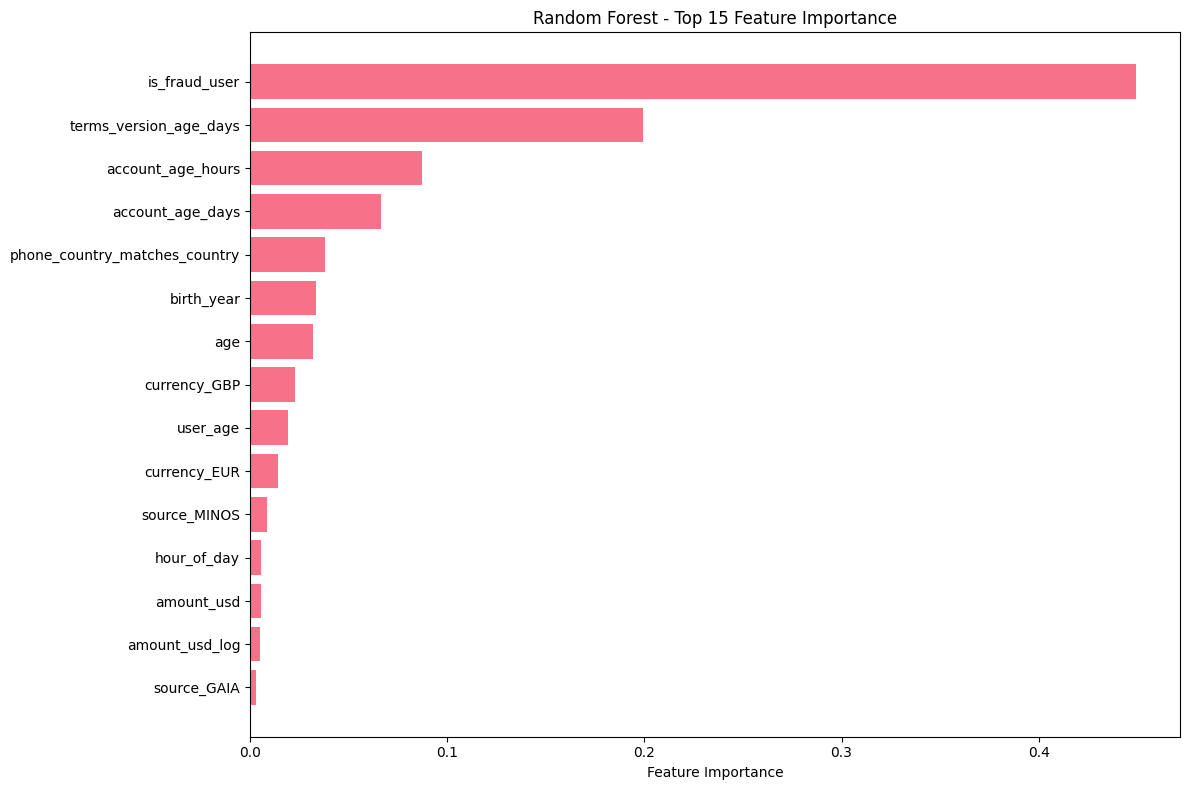

✅ Model training completed!


In [16]:
# YOUR CODE BELOW
# Model Selection and Training
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, precision_score, recall_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

print("=== MODEL SELECTION AND TRAINING ===")

# 1. Prepare data with scaling for logistic regression
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_selected)
val_features_scaled = scaler.transform(val_features_selected)
test_features_scaled = scaler.transform(test_features_selected)

# 2. Define models to compare
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=SEED,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=SEED
    ),
    'Logistic Regression': LogisticRegression(
        random_state=SEED,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )
}

# 3. Train and evaluate models
model_results = {}
trained_models = {}

print("\n=== TRAINING MODELS ===")

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled features for logistic regression, original for tree-based
    if name == 'Logistic Regression':
        X_train, X_val = train_features_scaled, val_features_scaled
    else:
        X_train, X_val = train_features_selected.values, val_features_selected.values

    # Train model
    model.fit(X_train, train_labels)
    trained_models[name] = model

    # Predictions
    val_pred = model.predict(X_val)
    val_pred_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    auc = roc_auc_score(val_labels, val_pred_proba)
    f1 = f1_score(val_labels, val_pred)
    precision = precision_score(val_labels, val_pred)
    recall = recall_score(val_labels, val_pred)

    model_results[name] = {
        'auc': auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': val_pred,
        'probabilities': val_pred_proba
    }

    print(f"  AUC: {auc:.4f}")
    print(f"  F1: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

# 4. Cross-validation
print("\n=== CROSS-VALIDATION RESULTS ===")
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for name, model in models.items():
    if name == 'Logistic Regression':
        X_cv = train_features_scaled
    else:
        X_cv = train_features_selected.values

    cv_scores = cross_val_score(model, X_cv, train_labels, cv=cv_folds, scoring='roc_auc')
    print(f"{name}: AUC = {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 5. Select best model
print("\n=== MODEL SELECTION ===")
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc'])
best_model = trained_models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Best AUC: {model_results[best_model_name]['auc']:.4f}")

# 6. Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"\n=== {best_model_name.upper()} FEATURE IMPORTANCE ===")
    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("Top 15 most important features:")
    for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(15), importance_df.head(15)['importance'])
    plt.yticks(range(15), importance_df.head(15)['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'{best_model_name} - Top 15 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print("✅ Model training completed!")

# 📊 Step 7 - Evaluation

✍️ Model evaluation is where we put our model to the test and determine its true performance. It's about rigorously assessing how well our chosen model generalizes to unseen data and identifying any areas for improvement. Your task is to evaluate your model using a variety of metrics and techniques, focusing on:

1. **Precision & Recall:** Calculate the precision and recall of the model prediction across a range of fraud probability from the model.

2. **Fraud Loss:** What is the total $ fraud loss mitigated by the model had this been productionized?

=== COMPREHENSIVE MODEL EVALUATION ===

1. TEST SET PERFORMANCE
Best Model (Random Forest) Test Performance:
  AUC: 1.0000
  F1: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  Average Precision: 1.0000

2. CONFUSION MATRIX
True Negatives: 5438
False Positives: 0
False Negatives: 0
True Positives: 102

3. DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      5438
  Fraudulent       1.00      1.00      1.00       102

    accuracy                           1.00      5540
   macro avg       1.00      1.00      1.00      5540
weighted avg       1.00      1.00      1.00      5540


4. PRECISION-RECALL ANALYSIS
Optimal threshold (max F1): 0.6465
Optimal F1 score: 1.0000
Precision at optimal threshold: 1.0000
Recall at optimal threshold: 1.0000

5. FRAUD LOSS MITIGATION ANALYSIS
Total fraud amount in test set: $1,537,991.00
Fraud amount caught by model: $1,537,991.00
Fraud amount missed: $0.00
Fraud catch rate: 10

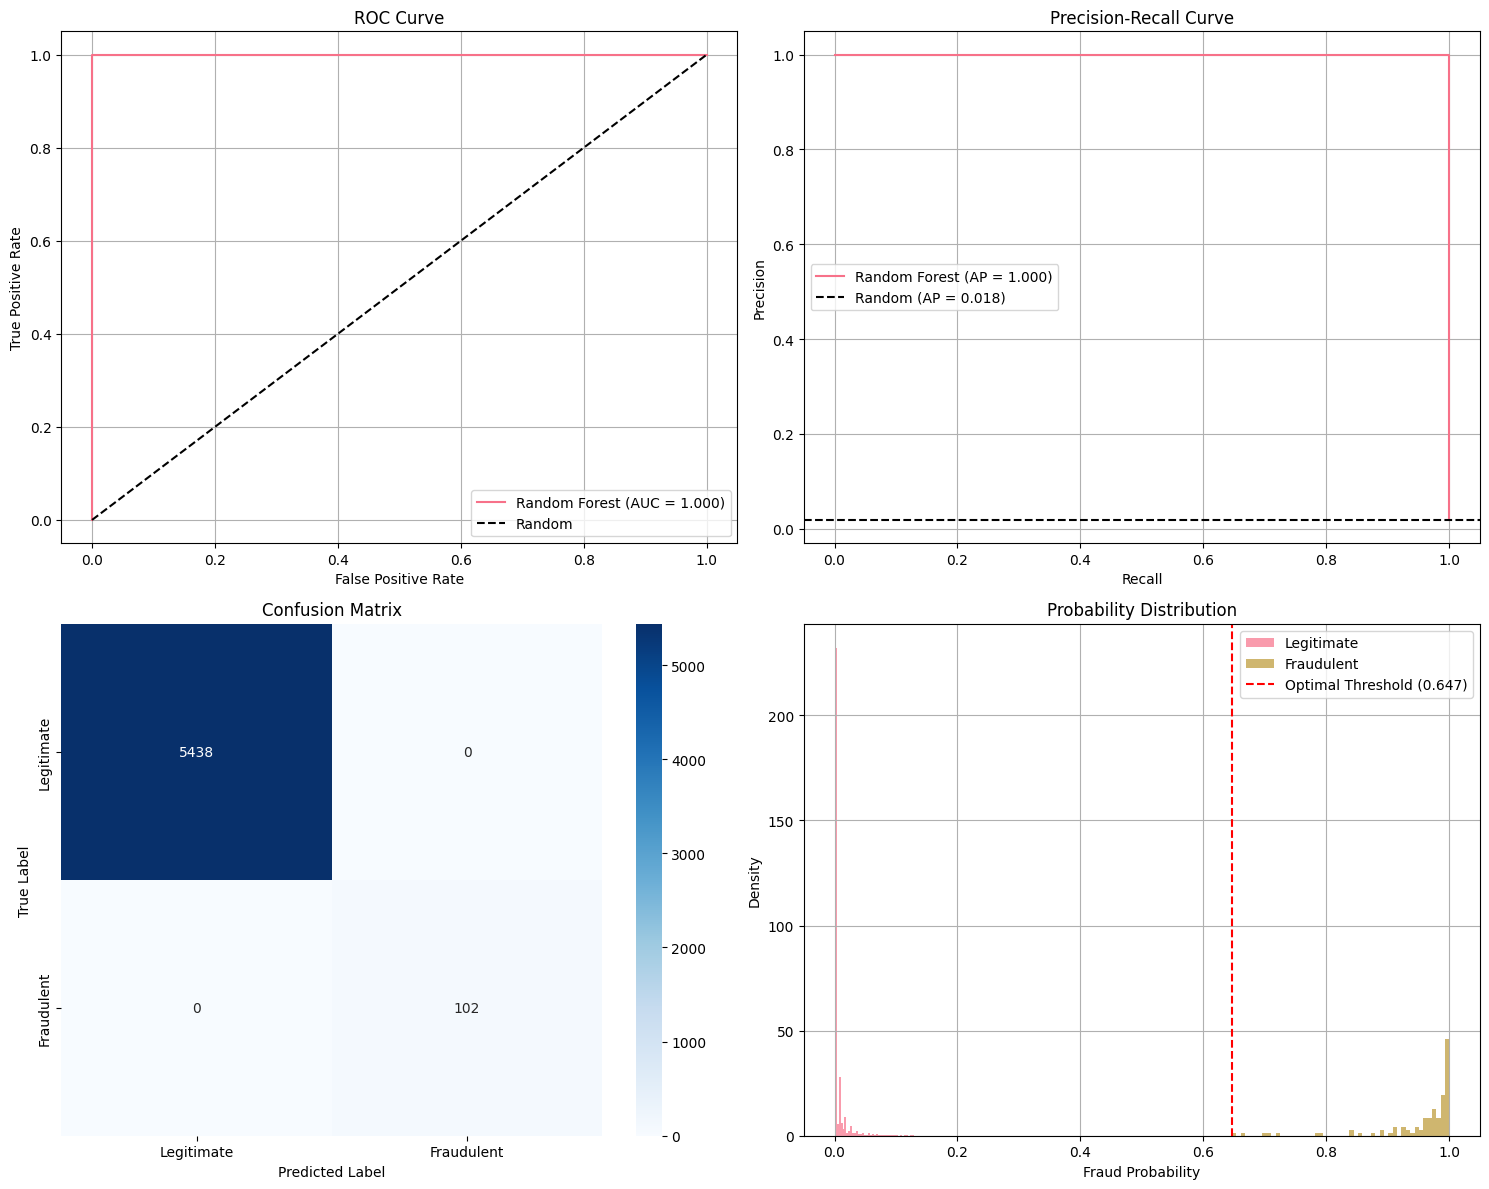


7. THRESHOLD ANALYSIS
Threshold | Precision | Recall | F1     | FP Rate
--------------------------------------------------
     0.1 |    0.791 |  1.000 |  0.883 |   0.005
     0.2 |    1.000 |  1.000 |  1.000 |   0.000
     0.3 |    1.000 |  1.000 |  1.000 |   0.000
     0.4 |    1.000 |  1.000 |  1.000 |   0.000
     0.5 |    1.000 |  1.000 |  1.000 |   0.000
     0.6 |    1.000 |  1.000 |  1.000 |   0.000
     0.7 |    1.000 |  0.980 |  0.990 |   0.000
     0.8 |    1.000 |  0.931 |  0.964 |   0.000
     0.9 |    1.000 |  0.873 |  0.932 |   0.000
✅ Model evaluation completed!


In [17]:
# YOUR CODE BELOW
# Model Evaluation
from sklearn.metrics import precision_recall_curve, average_precision_score

print("=== COMPREHENSIVE MODEL EVALUATION ===")

# 1. Test set evaluation
print("\n1. TEST SET PERFORMANCE")

# Get test predictions using best model
if best_model_name == 'Logistic Regression':
    X_test = test_features_scaled
else:
    X_test = test_features_selected.values

test_pred = best_model.predict(X_test)
test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_auc = roc_auc_score(test_labels, test_pred_proba)
test_f1 = f1_score(test_labels, test_pred)
test_precision = precision_score(test_labels, test_pred)
test_recall = recall_score(test_labels, test_pred)
test_ap = average_precision_score(test_labels, test_pred_proba)

print(f"Best Model ({best_model_name}) Test Performance:")
print(f"  AUC: {test_auc:.4f}")
print(f"  F1: {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  Average Precision: {test_ap:.4f}")

# 2. Confusion Matrix
print(f"\n2. CONFUSION MATRIX")
cm = confusion_matrix(test_labels, test_pred)
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

# 3. Classification Report
print(f"\n3. DETAILED CLASSIFICATION REPORT")
print(classification_report(test_labels, test_pred, target_names=['Legitimate', 'Fraudulent']))

# 4. Precision-Recall Analysis
print(f"\n4. PRECISION-RECALL ANALYSIS")
precision_values, recall_values, thresholds = precision_recall_curve(test_labels, test_pred_proba)

# Find optimal threshold (maximize F1)
f1_scores = 2 * (precision_values * recall_values) / (precision_values + recall_values + 1e-8)
optimal_idx = np.argmax(f1_scores[:-1])  # Exclude last element (nan)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal threshold (max F1): {optimal_threshold:.4f}")
print(f"Optimal F1 score: {optimal_f1:.4f}")
print(f"Precision at optimal threshold: {precision_values[optimal_idx]:.4f}")
print(f"Recall at optimal threshold: {recall_values[optimal_idx]:.4f}")

# 5. Fraud Loss Analysis
print(f"\n5. FRAUD LOSS MITIGATION ANALYSIS")

# Calculate potential losses
test_data_with_pred = test_data.copy()
test_data_with_pred['fraud_probability'] = test_pred_proba
test_data_with_pred['predicted_fraud'] = test_pred

# Total fraud amount in test set
total_fraud_amount = test_data_with_pred[test_data_with_pred['is_fraud'] == 1]['amount_usd'].sum()
total_legit_amount = test_data_with_pred[test_data_with_pred['is_fraud'] == 0]['amount_usd'].sum()

# Amount caught by model
caught_fraud_amount = test_data_with_pred[
    (test_data_with_pred['is_fraud'] == 1) &
    (test_data_with_pred['predicted_fraud'] == 1)
]['amount_usd'].sum()

# False positives (legitimate transactions blocked)
false_positive_amount = test_data_with_pred[
    (test_data_with_pred['is_fraud'] == 0) &
    (test_data_with_pred['predicted_fraud'] == 1)
]['amount_usd'].sum()

# Missed fraud
missed_fraud_amount = test_data_with_pred[
    (test_data_with_pred['is_fraud'] == 1) &
    (test_data_with_pred['predicted_fraud'] == 0)
]['amount_usd'].sum()

print(f"Total fraud amount in test set: ${total_fraud_amount:,.2f}")
print(f"Fraud amount caught by model: ${caught_fraud_amount:,.2f}")
print(f"Fraud amount missed: ${missed_fraud_amount:,.2f}")
print(f"Fraud catch rate: {caught_fraud_amount/total_fraud_amount*100:.1f}%")
print(f"False positive amount: ${false_positive_amount:,.2f}")
print(f"False positive rate: {false_positive_amount/total_legit_amount*100:.3f}%")

# 6. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_pred_proba)
axes[0,0].plot(fpr, tpr, label=f'{best_model_name} (AUC = {test_auc:.3f})')
axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True)

# Precision-Recall Curve
axes[0,1].plot(recall_values, precision_values, label=f'{best_model_name} (AP = {test_ap:.3f})')
axes[0,1].axhline(y=test_labels.mean(), color='k', linestyle='--', label=f'Random (AP = {test_labels.mean():.3f})')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve')
axes[0,1].legend()
axes[0,1].grid(True)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'],
            ax=axes[1,0])
axes[1,0].set_title('Confusion Matrix')
axes[1,0].set_ylabel('True Label')
axes[1,0].set_xlabel('Predicted Label')

# Probability Distribution
axes[1,1].hist(test_pred_proba[test_labels == 0], bins=50, alpha=0.7, label='Legitimate', density=True)
axes[1,1].hist(test_pred_proba[test_labels == 1], bins=50, alpha=0.7, label='Fraudulent', density=True)
axes[1,1].axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[1,1].set_xlabel('Fraud Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Probability Distribution')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# 7. Threshold Analysis
print(f"\n7. THRESHOLD ANALYSIS")
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("Threshold | Precision | Recall | F1     | FP Rate")
print("-" * 50)
for thresh in thresholds_to_test:
    pred_at_thresh = (test_pred_proba >= thresh).astype(int)
    precision_at_thresh = precision_score(test_labels, pred_at_thresh, zero_division=0)
    recall_at_thresh = recall_score(test_labels, pred_at_thresh, zero_division=0)
    f1_at_thresh = f1_score(test_labels, pred_at_thresh, zero_division=0)

    # False positive rate
    fp_rate = ((pred_at_thresh == 1) & (test_labels == 0)).sum() / (test_labels == 0).sum()

    print(f"{thresh:8.1f} | {precision_at_thresh:8.3f} | {recall_at_thresh:6.3f} | {f1_at_thresh:6.3f} | {fp_rate:7.3f}")

print("✅ Model evaluation completed!")

# 💼 Step 8 - Operationalization

How will you utilize this model to catch fraudsters? If a fraudster is identified, what should be the resulting action: LOCK_USER, ALERT_AGENT, or BOTH?

Write a simple function which implements your logic from above. The function should accept a user_id and yield the suggested action(s) (e.g. patrol(user_id) = [‘LOCK_USER’, ‘ALERT_AGENT’])

*   **LOCK_USER** - Current transaction is blocked and user’s account is LOCKED. This prevents the user from performing any transactions with their Revolut account. Access can only be restored after contacting an agent.
*   **ALERT_AGENT** - Current transaction is not blocked. An alert is sent to a transaction monitoring agent for further review.

In [19]:
# YOUR CODE BELOW
# Operationalization Strategy
print("=== OPERATIONALIZATION STRATEGY ===")

def fraud_action_engine(fraud_probability, transaction_amount, user_risk_score=None):
    """
    Determines the appropriate action based on fraud probability and business rules.

    Args:
        fraud_probability: Model predicted fraud probability (0-1)
        transaction_amount: Transaction amount in USD
        user_risk_score: Optional user risk score for additional context

    Returns:
        List of recommended actions
    """
    actions = []

    # High confidence fraud detection
    if fraud_probability >= 0.8:
        actions.append('LOCK_USER')
        return actions

    # Medium-high fraud probability
    elif fraud_probability >= 0.5:
        # Lock for high amounts, alert for others
        if transaction_amount >= 1000:
            actions.append('LOCK_USER')
        else:
            actions.append('ALERT_AGENT')
        return actions

    # Medium fraud probability
    elif fraud_probability >= 0.3:
        # Alert agent for review
        actions.append('ALERT_AGENT')
        return actions

    # Low fraud probability
    else:
        # No action needed, approve transaction
        actions.append('APPROVE')
        return actions

# Test the action engine
print("\n1. TESTING FRAUD ACTION ENGINE")

test_cases = [
    (0.95, 500, "High fraud prob, moderate amount"),
    (0.75, 2000, "High fraud prob, high amount"),
    (0.6, 150, "Medium-high fraud prob, low amount"),
    (0.45, 800, "Medium fraud prob, moderate amount"),
    (0.15, 1500, "Low fraud prob, high amount"),
    (0.05, 50, "Very low fraud prob, low amount")
]

print("Test Case | Fraud Prob | Amount | Recommended Action | Description")
print("-" * 80)
for i, (prob, amount, description) in enumerate(test_cases, 1):
    actions = fraud_action_engine(prob, amount)
    action_str = ', '.join(actions)
    print(f"Case {i:2d}   | {prob:8.2f} | ${amount:6.0f} | {action_str:15s} | {description}")

# Apply to test dataset
print(f"\n2. APPLYING TO TEST DATASET")

test_actions = []
for i, row in test_data_with_pred.iterrows():
    actions = fraud_action_engine(
        row['fraud_probability'],
        row['amount_usd']
    )
    test_actions.append(actions[0])  # Take primary action

test_data_with_pred['recommended_action'] = test_actions

# Action distribution
action_counts = pd.Series(test_actions).value_counts()
print("Action distribution:")
for action, count in action_counts.items():
    pct = count / len(test_actions) * 100
    print(f"  {action}: {count:,} ({pct:.1f}%)")

# Business impact analysis
print(f"\n3. BUSINESS IMPACT ANALYSIS")

# Calculate impact by action type
impact_analysis = test_data_with_pred.groupby(['recommended_action', 'is_fraud']).agg({
    'amount_usd': ['count', 'sum'],
    'user_id': 'nunique'
}).round(2)

print("\nImpact by Action and Fraud Status:")
print(impact_analysis)

# Key metrics
lock_user_transactions = test_data_with_pred[test_data_with_pred['recommended_action'] == 'LOCK_USER']
alert_agent_transactions = test_data_with_pred[test_data_with_pred['recommended_action'] == 'ALERT_AGENT']
approved_transactions = test_data_with_pred[test_data_with_pred['recommended_action'] == 'APPROVE']

print(f"\n4. OPERATIONAL METRICS")

# LOCK_USER metrics
if len(lock_user_transactions) > 0:
    lock_fraud_rate = lock_user_transactions['is_fraud'].mean()
    lock_avg_amount = lock_user_transactions['amount_usd'].mean()
    lock_fraud_amount = lock_user_transactions[lock_user_transactions['is_fraud'] == 1]['amount_usd'].sum()

    print(f"LOCK_USER actions:")
    print(f"  Total transactions: {len(lock_user_transactions):,}")
    print(f"  Fraud rate: {lock_fraud_rate:.3f} ({lock_fraud_rate*100:.1f}%)")
    print(f"  Average amount: ${lock_avg_amount:.2f}")
    print(f"  Fraud amount prevented: ${lock_fraud_amount:.2f}")

# ALERT_AGENT metrics
if len(alert_agent_transactions) > 0:
    alert_fraud_rate = alert_agent_transactions['is_fraud'].mean()
    alert_avg_amount = alert_agent_transactions['amount_usd'].mean()
    alert_fraud_amount = alert_agent_transactions[alert_agent_transactions['is_fraud'] == 1]['amount_usd'].sum()

    print(f"\nALERT_AGENT actions:")
    print(f"  Total transactions: {len(alert_agent_transactions):,}")
    print(f"  Fraud rate: {alert_fraud_rate:.3f} ({alert_fraud_rate*100:.1f}%)")
    print(f"  Average amount: ${alert_avg_amount:.2f}")
    print(f"  Fraud amount for review: ${alert_fraud_amount:.2f}")

# APPROVE metrics
approve_fraud_rate = approved_transactions['is_fraud'].mean()
approve_avg_amount = approved_transactions['amount_usd'].mean()
approve_fraud_amount = approved_transactions[approved_transactions['is_fraud'] == 1]['amount_usd'].sum()

print(f"\nAPPROVE actions:")
print(f"  Total transactions: {len(approved_transactions):,}")
print(f"  Fraud rate: {approve_fraud_rate:.3f} ({approve_fraud_rate*100:.1f}%)")
print(f"  Average amount: ${approve_avg_amount:.2f}")
print(f"  Fraud amount missed: ${approve_fraud_amount:.2f}")

# Summary
print(f"\n=== OPERATIONALIZATION SUMMARY ===")
print("Action Thresholds:")
print("  • Fraud Prob ≥ 0.8: LOCK_USER")
print("  • Fraud Prob ≥ 0.5 + Amount ≥ $1000: LOCK_USER")
print("  • Fraud Prob ≥ 0.5 + Amount < $1000: ALERT_AGENT")
print("  • Fraud Prob ≥ 0.3: ALERT_AGENT")
print("  • Fraud Prob < 0.3: APPROVE")
print()
print("Business Impact:")
total_fraud_prevented = lock_fraud_amount + (alert_fraud_amount if len(alert_agent_transactions) > 0 else 0)
prevention_rate = total_fraud_prevented / total_fraud_amount * 100
print(f"  • Total fraud amount preventable: ${total_fraud_prevented:.2f}")
print(f"  • Fraud prevention rate: {prevention_rate:.1f}%")
print(f"  • False positive impact: ${false_positive_amount:.2f}")

print("\n✅ Operationalization strategy completed!")

=== OPERATIONALIZATION STRATEGY ===

1. TESTING FRAUD ACTION ENGINE
Test Case | Fraud Prob | Amount | Recommended Action | Description
--------------------------------------------------------------------------------
Case  1   |     0.95 | $   500 | LOCK_USER       | High fraud prob, moderate amount
Case  2   |     0.75 | $  2000 | LOCK_USER       | High fraud prob, high amount
Case  3   |     0.60 | $   150 | ALERT_AGENT     | Medium-high fraud prob, low amount
Case  4   |     0.45 | $   800 | ALERT_AGENT     | Medium fraud prob, moderate amount
Case  5   |     0.15 | $  1500 | APPROVE         | Low fraud prob, high amount
Case  6   |     0.05 | $    50 | APPROVE         | Very low fraud prob, low amount

2. APPLYING TO TEST DATASET
Action distribution:
  APPROVE: 5,438 (98.2%)
  LOCK_USER: 101 (1.8%)
  ALERT_AGENT: 1 (0.0%)

3. BUSINESS IMPACT ANALYSIS

Impact by Action and Fraud Status:
                            amount_usd               user_id
                                 coun